# Exploratoy Data Analysis (EDA)

Exploratory Data Analysis to diagnose mexican economy.

The main goal of this particular project is to analyze some economic parameters of interest to understand the statistical behavior (over time) of the study parameters and their influence or relationship during the economy crisis that have occurred in Mexico since 1990 until today, through Data Science techniques.

> Elias Castellanos Alamilla

> April-2023

## Load dependencies

In [1]:
# Data manipulation
import pandas as pd

# Math's/basic statistic's
import numpy as np

# Data viz
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.express as px

# OS
import os
import random

# Import notebook as functions
import import_ipynb

In [2]:
from my_functions import (
    plot_colortable,
    seasonal_decomposition,
    read_sql_data,
    send_sql_data, 
    compare_and_aggregate
)

importing Jupyter notebook from my_functions.ipynb


## Problem definition

We want to study the behavior of certain Mexican economic indicators (annual INPC, CETES, dls/mxn, UDI's) to understand from a statistical perspective, the "recent" economic history of Mexico in order to be able to establish personal financial strategies. i.e. Is it convenient to take a bank loan with a variable interest rate in inflationary times?

Questions to answer:

Is there any relationship between the indicators established with the economic record of the country?
If so, how strong is that relationship?
Which variable has the higher impact on historical behavior?
How can we discretize economic history into categories or data sets?

## Hypothesis

Based on the global uncertainty about inflation and bank stability...exists the probability that inflation values in Mexico rise again, hence, we need to keep cautious in personal expenses for the next 12 months.

## Load Data

In [4]:
# Check-create dir
if not os.path.exists('./viz'):
    os.mkdir('./viz')

In [5]:
db_connection = {
    'host': '127.0.0.1',
    'user': 'mrrobot',
    'password': 'esto es una base de datos relacional',
    'db': 'mei',
}

In [6]:
indicadores_mx = read_sql_data(db_connection, 'indicadores_mx')

In [7]:
indicadores_mx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   fecha                     399 non-null    datetime64[ns]
 1   dls_mxn                   399 non-null    float64       
 2   UDI                       336 non-null    float64       
 3   MME                       327 non-null    float64       
 4   CETES                     399 non-null    float64       
 5   inflacion_anual           399 non-null    float64       
 6   interes_interbancario_28  337 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 21.9 KB


In [8]:
indicadores_mx.set_index('fecha', inplace=True)

<Axes: xlabel='fecha'>

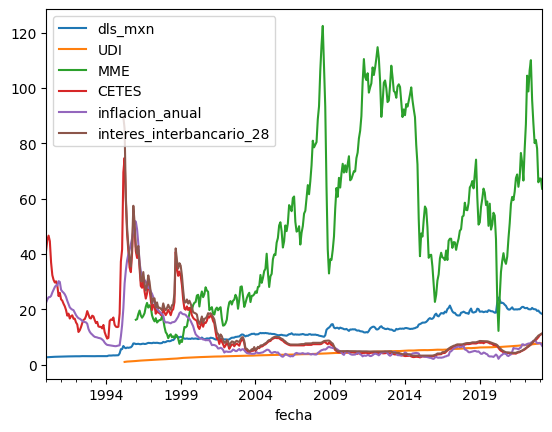

In [9]:
indicadores_mx.plot()

In [10]:
indicadores_mx.head()

,dls_mxn,UDI,MME,CETES,inflacion_anual,interes_interbancario_28
fecha,,,,,,
1990-01-01,2.701659,NaN,NaN,41.29,22.48,NaN
1990-02-01,2.731658,NaN,NaN,45.20,23.57,NaN
1990-03-01,2.760357,NaN,NaN,46.65,24.40,NaN
1990-04-01,2.791184,NaN,NaN,44.64,24.43,NaN
1990-05-01,2.821791,NaN,NaN,36.92,24.89,NaN


In [11]:
indicadores_mx.tail()

,dls_mxn,UDI,MME,CETES,inflacion_anual,interes_interbancario_28
fecha,,,,,,
2022-11-01,19.444915,7.593800,78.078235,9.42,7.80,9.998965
2022-12-01,19.592962,7.637564,65.904000,9.96,7.82,10.525376
2023-01-01,18.986336,7.667540,67.256667,10.61,7.91,10.780886
2023-02-01,18.598568,7.715153,67.273889,10.92,7.62,11.101474
2023-03-01,18.374905,7.761490,63.583636,11.23,6.85,11.336627


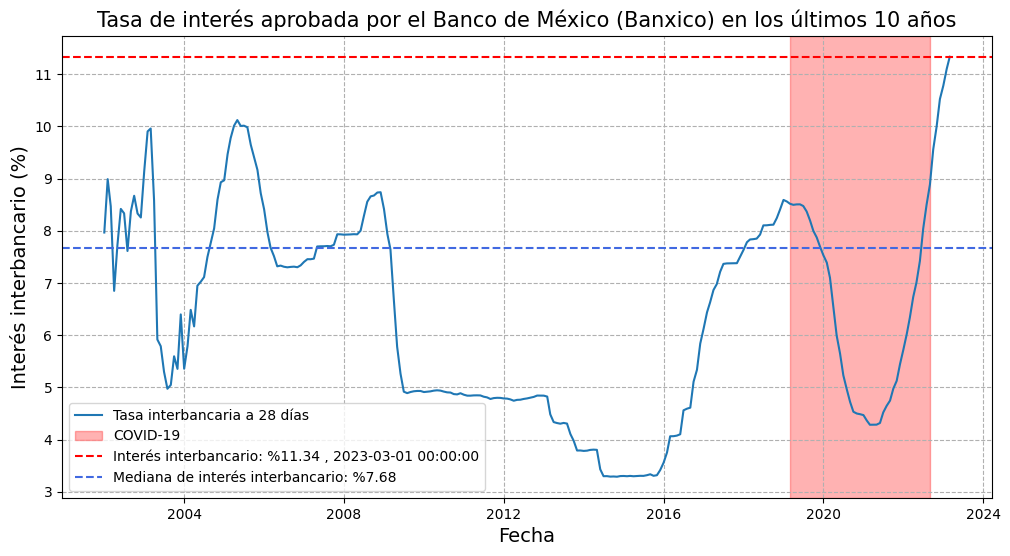

In [12]:
tasa_interbancaria = indicadores_mx['interes_interbancario_28']
last_date = tasa_interbancaria.index[-1]

fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(x=tasa_interbancaria['2002':].index, y=tasa_interbancaria['2002':], label='Tasa interbancaria a 28 días')

ax.set_xlabel('Fecha', fontsize=14)
ax.set_ylabel('Interés interbancario (%)', fontsize=14)
ax.set_title('Tasa de interés aprobada por el Banco de México (Banxico) en los últimos 10 años', fontsize=15)

ax.axvspan('2019-03-01', '2022-09-01', color='red', alpha=0.3, label='COVID-19')
ax.axhline(tasa_interbancaria[-1], label='Interés interbancario: %{} , {}'.format(round(tasa_interbancaria[-1], 2),last_date), linestyle='--', color='red')
ax.axhline(tasa_interbancaria.median(), label='Mediana de interés interbancario: %{}'.format(round(tasa_interbancaria.median(), 2)), linestyle='--', color='royalblue')

ax.grid(True, linestyle='--')
ax.legend()
plt.savefig('viz/historico_tasa_interbancaria_banxico_march_2023.svg')

plt.show()

In [13]:
tasa_interbancaria.describe().round(2)

count    337.00
mean      11.32
std       11.43
min        3.29
25%        4.89
50%        7.68
75%       10.01
max       89.48
Name: interes_interbancario_28, dtype: float64

In [14]:
pd.infer_freq(indicadores_mx.index)

'MS'

## Distributions

* Continuous data features.

Probability Distributions: 
Provide us the idea by visually looking the values we have in a particular column. For example if we have normally distributed graph but we found some dips at some values then we would check for the missing values which are forming those dips and similarly if we have quite distorted graph then we can use lognormal to normalize the values and get a bell shaped curve.

> Distribuciones discretas: 

1. _Bernoulli Distribution_
2. _Uniform Distribution_
3. _Binomial Distribution_
4. _Geometric Distribution_
5. _Poisson Distribution_
6. _Hyper-Geometric Distribution_
7. _Negative Binomial Distribution_

> Distribuciones continuas:

1. _Uniform Distribution_
2. _Normal Distribution_
3. _Exponential Distribution_
4. _Chi-squared Distribution_
5. _Gamma distribution_
6. _Student T-Distribution_
7. _F-Distribution_
8. _Log-Normal Distribution_

[Probability Distribution](https://towardsai.net/p/l/different-probability-distributions-part-2?utm_campaign=rop-content-recycle&utm_content=213814543&utm_medium=social&utm_source=linkedin&hss_channel=lcp-3740012)

[7 types of statistical distribution](https://datasciencedojo.com/blog/types-of-statistical-distributions-in-ml/)

[Pandas Density Documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.density.html)

In [15]:
# Statistical summary
indicadores_mx.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
dls_mxn,399.0,11.64,5.39,2.70,8.58,10.99,14.63,24.27
UDI,336.0,4.27,1.62,1.03,3.10,4.23,5.42,7.76
MME,327.0,51.16,29.56,7.56,24.50,47.69,69.70,122.40
CETES,399.0,11.94,10.80,2.67,4.58,7.47,16.21,74.75
inflacion_anual,399.0,9.50,9.33,2.13,3.98,5.29,10.34,51.97
interes_interbancario_28,337.0,11.32,11.43,3.29,4.89,7.68,10.01,89.48


C:\Users\ecast\AppData\Local\Temp\ipykernel_20108\3014035813.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  indicadores_mx.plot(kind='density', figsize=(10, 7), subplots=True, layout=(3, 2), sharex=False, grid=True, ax=ax)


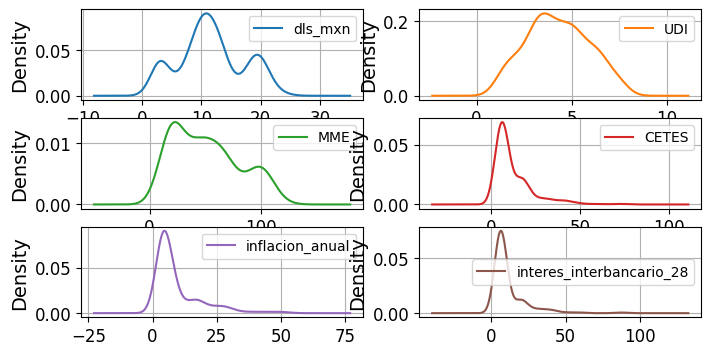

In [43]:
fig, ax = plt.subplots(figsize=(8, 4))

indicadores_mx.plot(kind='density', figsize=(10, 7), subplots=True, layout=(3, 2), sharex=False, grid=True, ax=ax)

plt.show()

## Feature description

* Mexican Peso: Relationship of the amount of pesos needed to acquire 1 US dollar. The higher the amount of pesos required, the weaker the national currency is with respect to the US dollar.

* National Consumer Price Index: Based on the second half of July 2018 (monthly), Inflation, Consumer Price Index (INPC), Annual Inflation.

* CETES: Bearer debt securities issued by the Federal Government since 1978, which obligates the government to pay their nominal value at maturity. This instrument was created to influence the regulation of the monetary mass, finance productive investment, and promote healthy development of the stock market. Through this mechanism, resources are collected from individuals and companies who are guaranteed a fixed income. The investor's return is the difference between the purchase and sale price. This instrument is placed through brokerage houses at a discount rate and has the backing of the Bank of Mexico, as the federal government's financial agent. [CETES](https://es.wikipedia.org/wiki/Certificados_de_la_Tesorer%C3%ADa_de_la_Federaci%C3%B3n)

* Investment Units (UDI): Investment Units (UDI) are value units established by the Bank of Mexico to meet the obligations of mortgage loans or any commercial or financial transaction. They began to be used in Mexico after the economic crisis of 1994-1995 by Sofoles, in order to provide the possibility of obtaining mortgage loans for individuals who were not eligible for credit in the country's financial institutions. Its value increases daily to maintain the purchasing power of money and is published in the Official Gazette of the Federation. The value of UDI is established taking into account the variations of the National Consumer Price Index (CPI), that is, taking into account inflation. This leads to fixed interest rates and stabilizes debts. [UDI's](https://es.wikipedia.org/wiki/Unidades_de_Inversi%C3%B3n)

* Interbank Interest Rate: The Equilibrium Interbank Interest Rate (TIIE) is a representative rate of credit operations between banks calculated by the Bank of Mexico. This rate is used as a reference to establish some commercial rates at the bank level. It can also be interpreted as a benchmark rate to assess the risk of acquiring a bank loan at a particular time. [TIIE](https://es.wikipedia.org/wiki/Tasa_de_inter%C3%A9s_interbancaria_de_equilibrio)

* Gross Domestic Product (GDP): GDP is the monetary value of final goods and services produced by an economy in a given period. GDP is a representative indicator that helps measure the growth or decline of the production of goods and services of each country's companies, solely within its territory. This indicator reflects the competitiveness of companies.
[PIB INEGI](https://www.inegi.org.mx/app/glosario/default.html?p=IPL2017)

## EDA 

[List of named colors in Matplotlib](https://matplotlib.org/stable/gallery/color/named_colors.html)

In [17]:
indicadores_mx.columns

Index(['dls_mxn', 'UDI', 'MME', 'CETES', 'inflacion_anual',
       'interes_interbancario_28'],
      dtype='object')

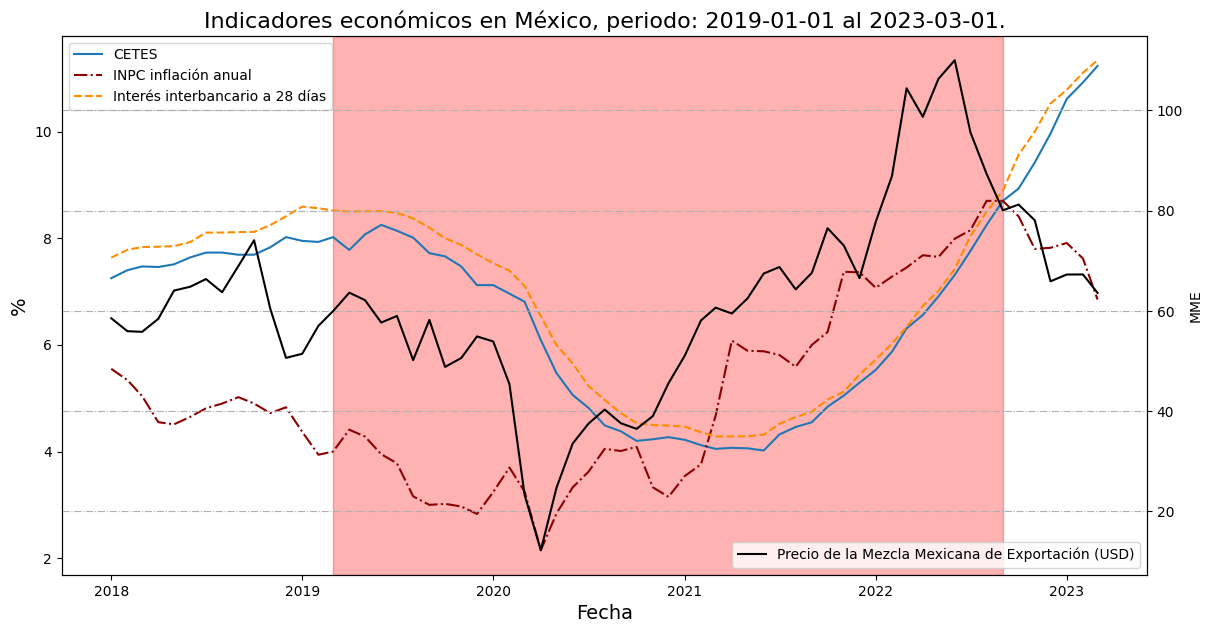

In [19]:
ultima_fecha = indicadores_mx.index[-1].date()
fecha_inicial = indicadores_mx['2019':].index[0].date()

fig, ax = plt.subplots(figsize=(14, 7))

sns.lineplot(data=indicadores_mx['2018':], x=indicadores_mx['2018':].index, y='CETES', label='CETES')
sns.lineplot(data=indicadores_mx['2018':], x=indicadores_mx['2018':].index, y='inflacion_anual', label='INPC inflación anual', color='darkred', linestyle='dashdot')
sns.lineplot(data=indicadores_mx['2018':], x=indicadores_mx['2018':].index, y='interes_interbancario_28', label='Interés interbancario a 28 días', linestyle='--', color='darkorange')

ax2 = ax.twinx()
sns.lineplot(data=indicadores_mx['2018':], x=indicadores_mx['2018':].index, y='MME', label='Precio de la Mezcla Mexicana de Exportación (USD)', color='black', ax=ax2)

plt.title('Indicadores económicos en México, periodo: {} al {}.'.format(fecha_inicial,ultima_fecha), fontsize=16)
ax.set_xlabel('Fecha', fontsize=14)
ax.set_ylabel('%', fontsize=14)
ax.axvspan('2019-03-01', '2022-09-01', color='red', alpha=0.3, label='COVID-19')

plt.grid(True, linestyle='dashdot')

plt.legend(loc='lower right')

plt.savefig('./viz/indicadores_mx_2019_2023.svg')

plt.show()

In [20]:
indicadores_mx.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
dls_mxn,399.0,11.64,5.39,2.70,8.58,10.99,14.63,24.27
UDI,336.0,4.27,1.62,1.03,3.10,4.23,5.42,7.76
MME,327.0,51.16,29.56,7.56,24.50,47.69,69.70,122.40
CETES,399.0,11.94,10.80,2.67,4.58,7.47,16.21,74.75
inflacion_anual,399.0,9.50,9.33,2.13,3.98,5.29,10.34,51.97
interes_interbancario_28,337.0,11.32,11.43,3.29,4.89,7.68,10.01,89.48


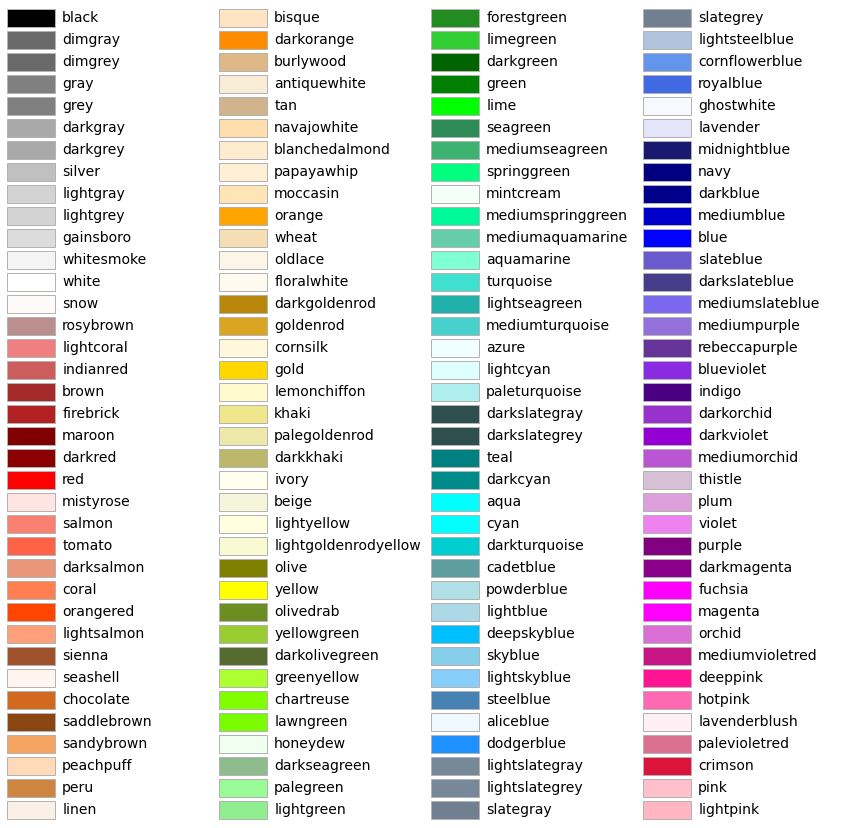

In [21]:
import matplotlib.colors as mcolors

plot_colortable(mcolors.CSS4_COLORS)
plt.show()

                          dls_mxn   UDI   MME  CETES  inflacion_anual  \
dls_mxn                      1.00  0.94  0.33  -0.56            -0.54   
UDI                          0.94  1.00  0.56  -0.66            -0.62   
MME                          0.33  0.56  1.00  -0.57            -0.45   
CETES                       -0.56 -0.66 -0.57   1.00             0.86   
inflacion_anual             -0.54 -0.62 -0.45   0.86             1.00   
interes_interbancario_28    -0.52 -0.67 -0.58   1.00             0.85   

                          interes_interbancario_28  
dls_mxn                                      -0.52  
UDI                                          -0.67  
MME                                          -0.58  
CETES                                         1.00  
inflacion_anual                               0.85  
interes_interbancario_28                      1.00  
----------------------------------------
       dls_mxn     UDI     MME   CETES  inflacion_anual  \
count   399.00  3

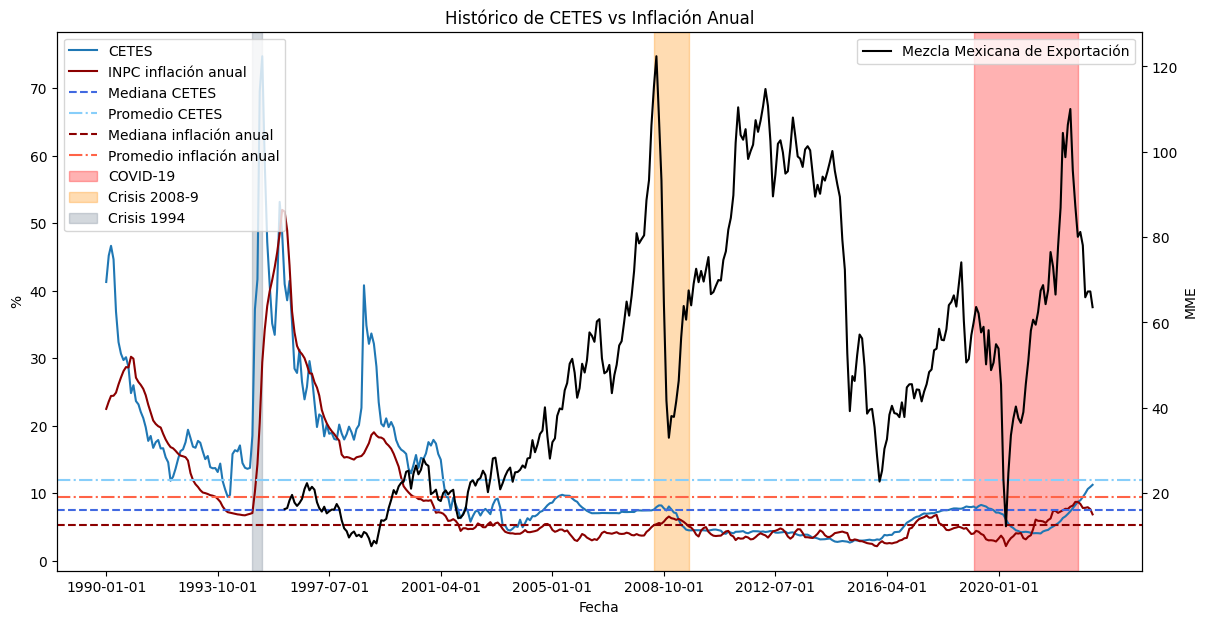

In [22]:
# supported values are '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

print(indicadores_mx.corr().round(2))
print("-"*40)
print(indicadores_mx.describe().round(2))
fig, ax = plt.subplots(figsize=(14, 7))

sns.lineplot(data=indicadores_mx, x=indicadores_mx.index, y='CETES', label='CETES')
sns.lineplot(data=indicadores_mx, x=indicadores_mx.index, y='inflacion_anual', label='INPC inflación anual', color='darkred')

ax2 = ax.twinx()
sns.lineplot(data=indicadores_mx, x=indicadores_mx.index, y='MME', label='Mezcla Mexicana de Exportación', color='black', ax=ax2)

ax.set_title('Histórico de CETES vs Inflación Anual')
ax.set_xlabel('Fecha')
ax.set_ylabel('%')
ax.set_xticks(indicadores_mx.index[::45])
# ax.xaxis.set_major_locator(mdates.YearLocator(month=1, day=1))

ax.axhline(indicadores_mx['CETES'].median(), label='Mediana CETES', linestyle='--', color='royalblue')
ax.axhline(indicadores_mx['CETES'].mean(), label='Promedio CETES', linestyle='dashdot', color='lightskyblue')
ax.axhline(indicadores_mx['inflacion_anual'].median(), label='Mediana inflación anual', linestyle='--', color='darkred')
ax.axhline(indicadores_mx['inflacion_anual'].mean(), label='Promedio inflación anual', linestyle='dashdot', color='tomato')
ax.axvspan('2019-03-01', '2022-09-01', color='red', alpha=0.3, label='COVID-19')
ax.axvspan('2008-06-01', '2009-08-01', color='darkorange', alpha=0.3, label='Crisis 2008-9')
ax.axvspan('1994-12-01', '1995-04-01', color='slategray', alpha=0.3, label='Crisis 1994')

# ax.grid(True, linestyle='--')
ax.legend(loc='upper left')

plt.savefig('./viz/analisis_CETES_INPC_march_2023.svg')
plt.show()

                          dls_mxn   UDI   MME  CETES  inflacion_anual  \
dls_mxn                      1.00  0.94  0.33  -0.56            -0.54   
UDI                          0.94  1.00  0.56  -0.66            -0.62   
MME                          0.33  0.56  1.00  -0.57            -0.45   
CETES                       -0.56 -0.66 -0.57   1.00             0.86   
inflacion_anual             -0.54 -0.62 -0.45   0.86             1.00   
interes_interbancario_28    -0.52 -0.67 -0.58   1.00             0.85   

                          interes_interbancario_28  
dls_mxn                                      -0.52  
UDI                                          -0.67  
MME                                          -0.58  
CETES                                         1.00  
inflacion_anual                               0.85  
interes_interbancario_28                      1.00  
--------------------------------------------------------------------------------
       dls_mxn     UDI     MME   CET

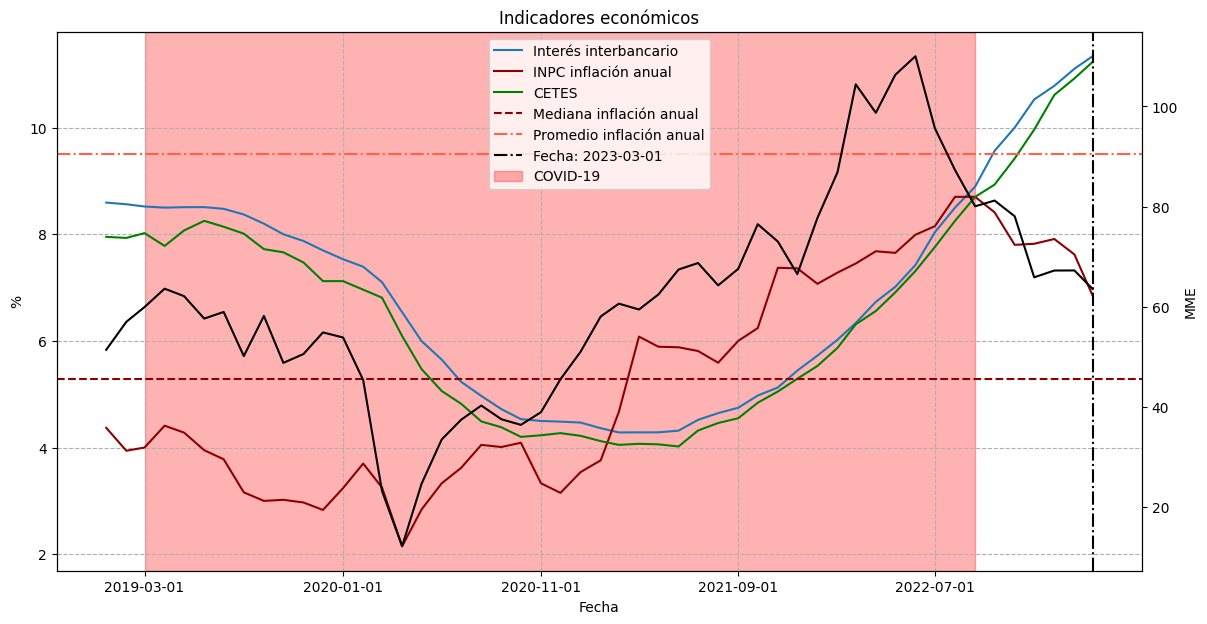

In [23]:
print(indicadores_mx.corr().round(2))
print("-"*80)
print(indicadores_mx.describe().round(2))
fig, ax = plt.subplots(figsize=(14, 7))

sns.lineplot(data=indicadores_mx['2019':], x=indicadores_mx['2019':].index, y='interes_interbancario_28', label='Interés interbancario')
sns.lineplot(data=indicadores_mx['2019':], x=indicadores_mx['2019':].index, y='inflacion_anual', label='INPC inflación anual', color='darkred')
sns.lineplot(data=indicadores_mx['2019':], x=indicadores_mx['2019':].index, y='CETES', label='CETES', color='green')

ax2 = ax.twinx()
sns.lineplot(data=indicadores_mx['2019':], x=indicadores_mx['2019':].index, y='MME', color='black', ax=ax2)
# ax2.set_ylabel('Precio de la Mezcla Mexicana de Exportación')

ax.set_title('Indicadores económicos')
ax.set_xlabel('Fecha')
ax.set_ylabel('%')
plt.xticks(indicadores_mx.index[::10], rotation=60)


# ax.axhline(indicadores_mx['CETES'].median(), label='Mediana CETES', linestyle='--', color='royalblue')
# ax.axhline(indicadores_mx['CETES'].mean(), label='Promedio CETES', linestyle='dashdot', color='lightskyblue')
ax.axhline(indicadores_mx['inflacion_anual'].median(), label='Mediana inflación anual', linestyle='--', color='darkred')
ax.axhline(indicadores_mx['inflacion_anual'].mean(), label='Promedio inflación anual', linestyle='dashdot', color='tomato')
ax.axvline(ultima_fecha, label='Fecha: {}'.format(ultima_fecha), linestyle='dashdot', color='black')
ax.axvspan('2019-03-01', '2022-09-01', color='red', alpha=0.3, label='COVID-19')
# ax.axvspan('2008-06-01', '2009-08-01', color='darkorange', alpha=0.3, label='Crisis 2008-9')
# ax.axvspan('1994-12-01', '1995-04-01', color='slategray', alpha=0.3, label='Crisis 1994')

ax.grid(True, linestyle='--')
ax.legend()

plt.savefig('./viz/analisis_CETES_INPC_2019_2023.svg')
plt.show()

In [24]:
indicadores_mx.loc[indicadores_mx.index == '2023-01-01'].transpose()

fecha,2023-01-01
dls_mxn,18.986336
UDI,7.667540
MME,67.256667
CETES,10.610000
inflacion_anual,7.910000
interes_interbancario_28,10.780886


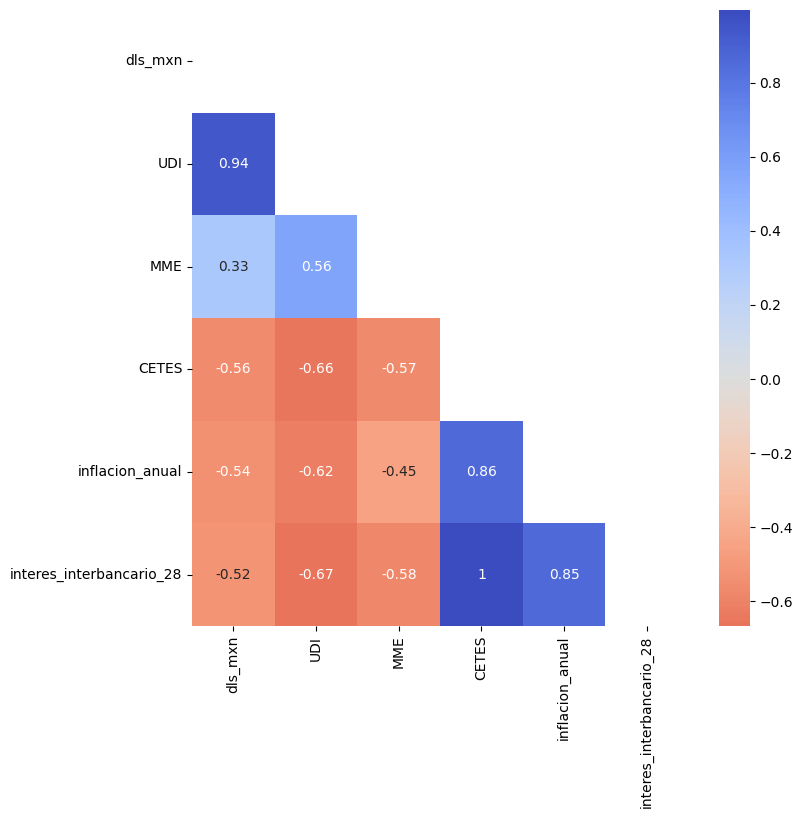

In [25]:
corr = indicadores_mx.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm_r', center=0)
plt.show()

* The Pearson Correlation between CETES and INPC is 0.86, we can consider good-high correlation. 

By descriptive statistics we can confirm that: 
* The median of CETES is 7.44%, while median of INPC is 5.18
* INPC (inflacion anual) at 2022-07-01 is 8.7%, that means 3.52% above the median.

                          dls_mxn   UDI   MME  CETES  inflacion_anual  \
dls_mxn                      1.00  0.94  0.33  -0.56            -0.54   
UDI                          0.94  1.00  0.56  -0.66            -0.62   
MME                          0.33  0.56  1.00  -0.57            -0.45   
CETES                       -0.56 -0.66 -0.57   1.00             0.86   
inflacion_anual             -0.54 -0.62 -0.45   0.86             1.00   
interes_interbancario_28    -0.52 -0.67 -0.58   1.00             0.85   

                          interes_interbancario_28  
dls_mxn                                      -0.52  
UDI                                          -0.67  
MME                                          -0.58  
CETES                                         1.00  
inflacion_anual                               0.85  
interes_interbancario_28                      1.00  
-------------------------
       dls_mxn     UDI     MME   CETES  inflacion_anual  \
count   399.00  336.00  327.00  

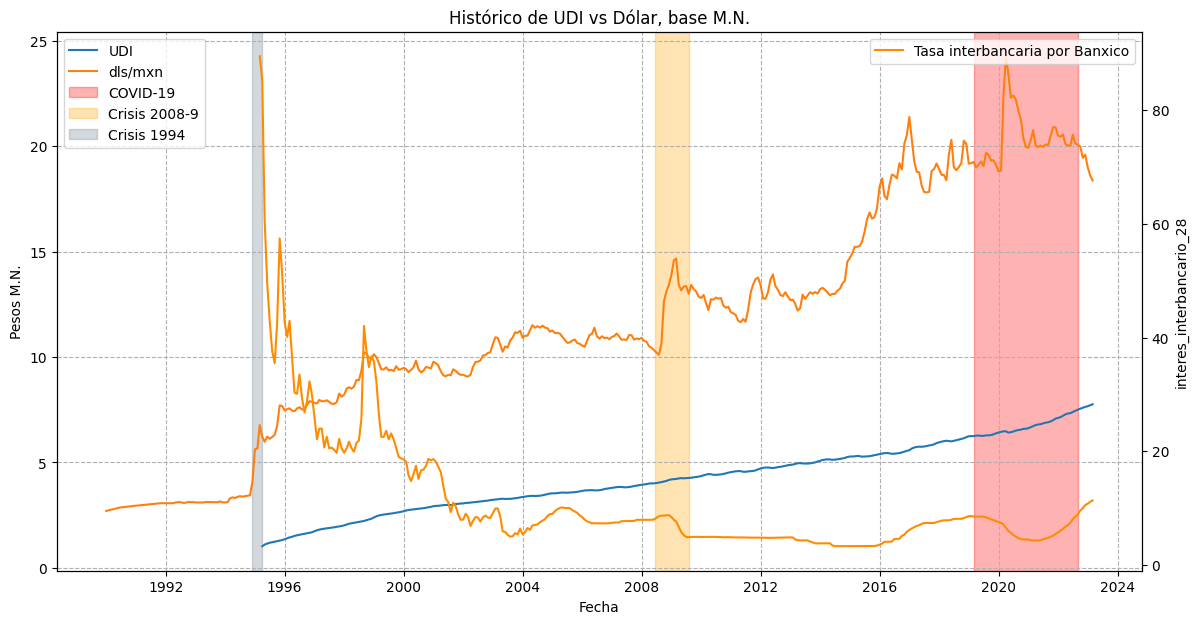

In [26]:
print(indicadores_mx.corr().round(2))
print("-"*25)
print(indicadores_mx.describe().round(2))

fig, ax = plt.subplots(figsize=(14, 7))

sns.lineplot(data=indicadores_mx, x=indicadores_mx.index, y='UDI', label='UDI')
sns.lineplot(data=indicadores_mx, x=indicadores_mx.index, y='dls_mxn', label='dls/mxn')

ax2 = ax.twinx()
sns.lineplot(data=indicadores_mx, x=indicadores_mx.index, y='interes_interbancario_28', color='darkorange',label='Tasa interbancaria por Banxico', ax=ax2)

ax.set_title('Histórico de UDI vs Dólar, base M.N.')
ax.set_xlabel('Fecha')
ax.set_ylabel('Pesos M.N.')

ax.axvspan('2019-03-11', '2022-09-01', color='red', alpha=0.3, label='COVID-19')
ax.axvspan('2008-06-11', '2009-08-01', color='orange', alpha=0.3, label='Crisis 2008-9')
ax.axvspan('1994-12-01', '1995-04-01', color='slategray', alpha=0.3, label='Crisis 1994')

ax.grid(True, linestyle='--')
ax.legend()
plt.show()

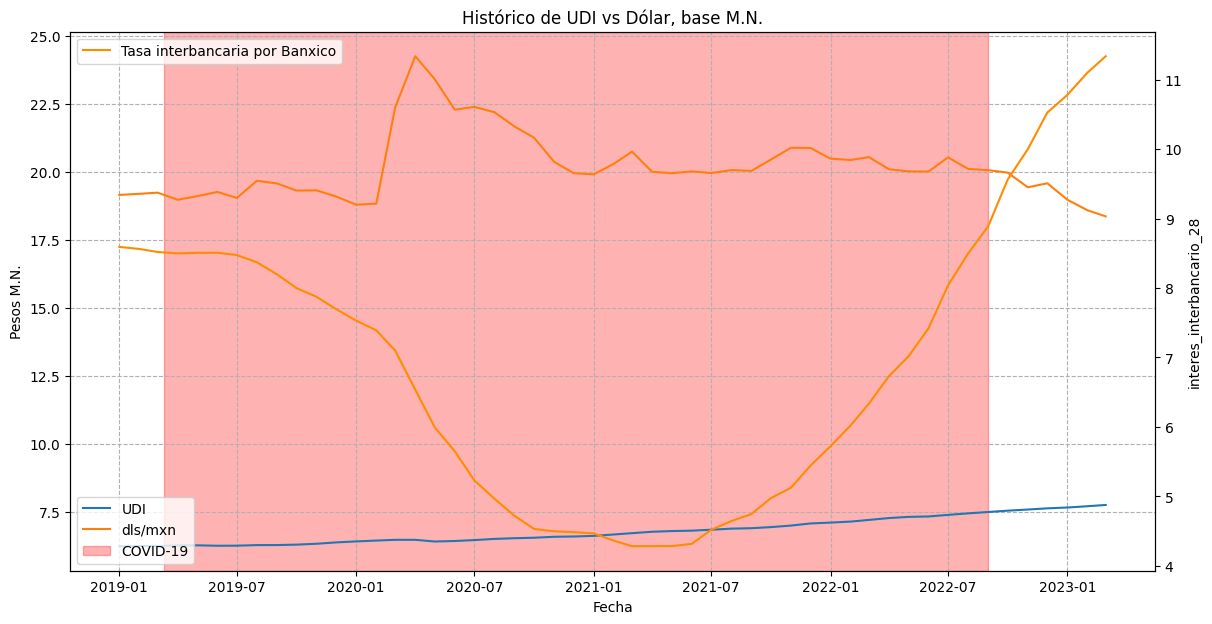

In [27]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.lineplot(data=indicadores_mx['2019':], x=indicadores_mx['2019':].index, y='UDI', label='UDI')
sns.lineplot(data=indicadores_mx['2019':], x=indicadores_mx['2019':].index, y='dls_mxn', label='dls/mxn')

ax2 = ax.twinx()
sns.lineplot(data=indicadores_mx['2019':], x=indicadores_mx['2019':].index, y='interes_interbancario_28', color='darkorange',label='Tasa interbancaria por Banxico', ax=ax2)

ax.set_title('Histórico de UDI vs Dólar, base M.N.')
ax.set_xlabel('Fecha')
ax.set_ylabel('Pesos M.N.')

ax.axvspan('2019-03-11', '2022-09-01', color='red', alpha=0.3, label='COVID-19')
# ax.axvspan('2008-06-11', '2009-08-01', color='orange', alpha=0.3, label='Crisis 2008-9')
# ax.axvspan('1994-12-01', '1995-04-01', color='slategray', alpha=0.3, label='Crisis 1994')

ax.grid(True, linestyle='--')
ax.legend(loc='lower left')
plt.show()

       dls_mxn     UDI   CETES  inflacion_anual
count   399.00  336.00  399.00           399.00
mean     11.64    4.27   11.94             9.50
std       5.39    1.62   10.80             9.33
min       2.70    1.03    2.67             2.13
25%       8.58    3.10    4.58             3.98
50%      10.99    4.23    7.47             5.29
75%      14.63    5.42   16.21            10.34
max      24.27    7.76   74.75            51.97
----------------------------------------------------------------------------------------------------


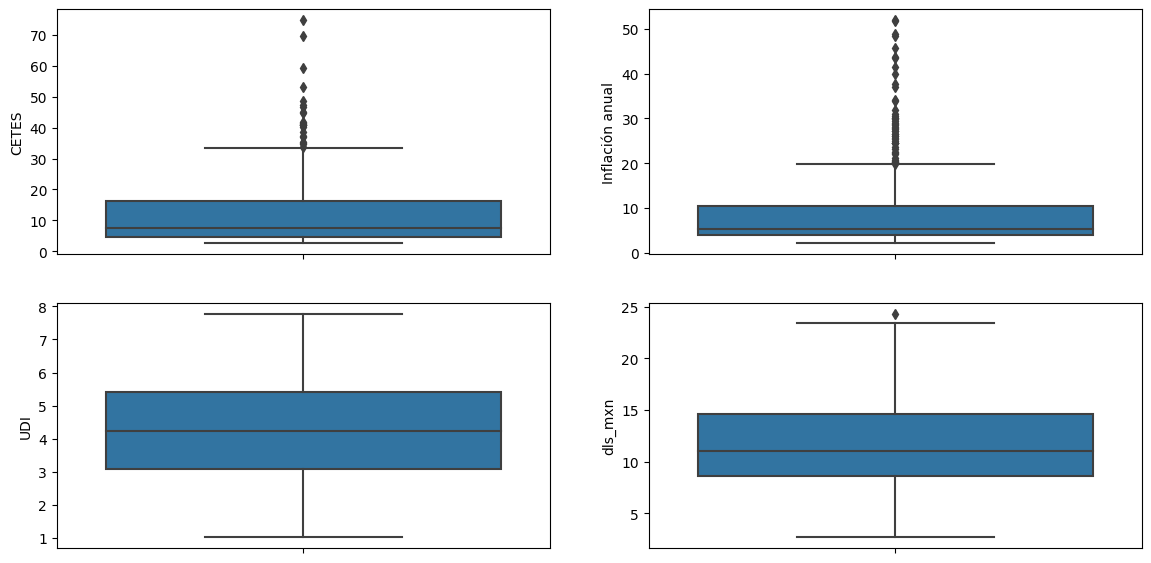

In [28]:
print(indicadores_mx.drop(["interes_interbancario_28", "MME"], axis=1).describe().round(2))
print("-"*100)
# print(indicadores.describe().round(2))

fig, ax = plt.subplots(2, 2, figsize=(14, 7))

sns.boxplot(data=indicadores_mx, y='CETES', ax=ax[0,0])
sns.boxplot(data=indicadores_mx, y='inflacion_anual', ax=ax[0,1])
sns.boxplot(data=indicadores_mx, y='UDI', ax=ax[1,0])
sns.boxplot(data=indicadores_mx, y='dls_mxn', ax=ax[1,1])

ax[0, 1].set_ylabel('Inflación anual')

plt.show()

       interes_interbancario_28     MME
count                    337.00  327.00
mean                      11.32   51.16
std                       11.43   29.56
min                        3.29    7.56
25%                        4.89   24.50
50%                        7.68   47.69
75%                       10.01   69.70
max                       89.48  122.40
------------------------------


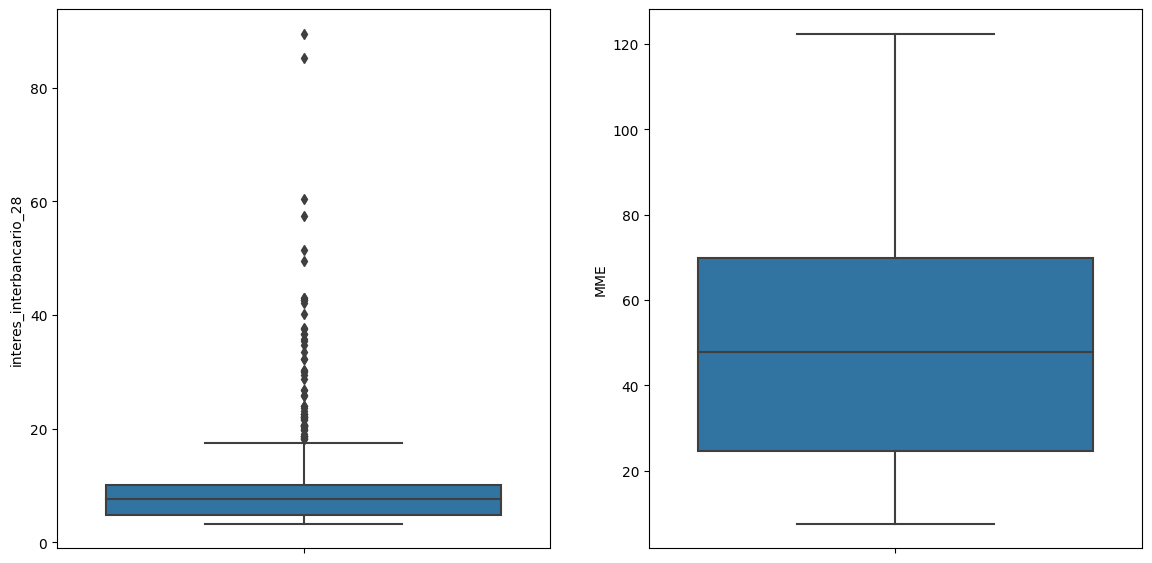

In [29]:
print(indicadores_mx[["interes_interbancario_28", "MME"]].describe().round(2))
print("-"*30)
# print(indicadores.describe().round(2))

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

sns.boxplot(data=indicadores_mx, y='interes_interbancario_28', ax=ax[0])
sns.boxplot(data=indicadores_mx, y='MME', ax=ax[1])

# ax[0, 1].set_ylabel('')

plt.show()

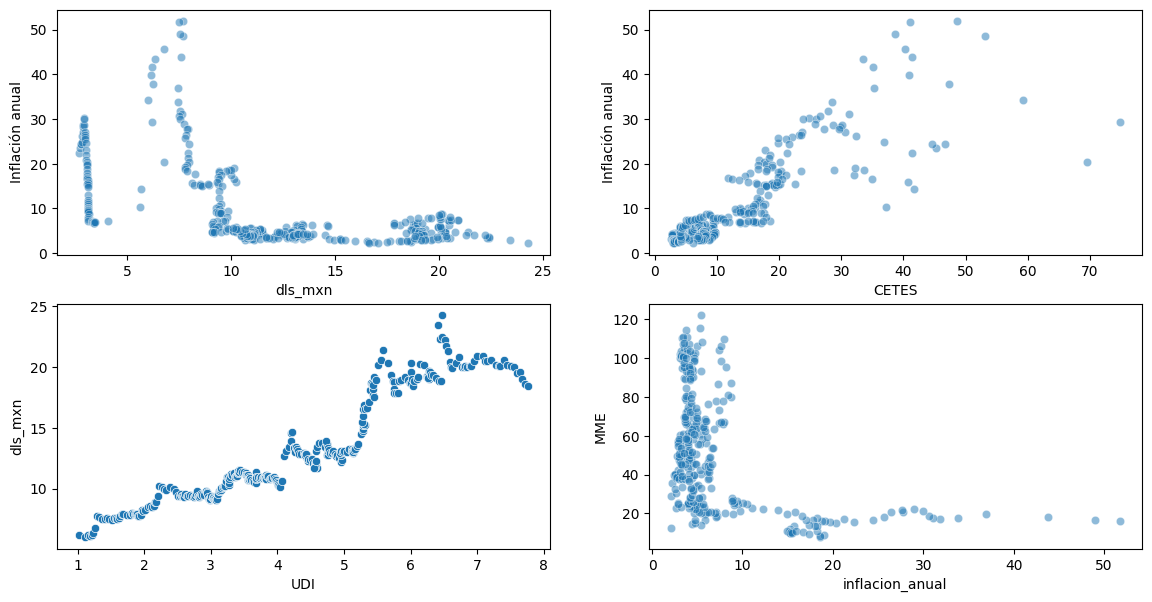

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(14, 7))

sns.scatterplot(x=indicadores_mx['dls_mxn'], y=indicadores_mx['inflacion_anual'], ax=ax[0,0], alpha=0.5)
sns.scatterplot(data=indicadores_mx, x='CETES', y='inflacion_anual', ax=ax[0,1], alpha=0.5)
sns.scatterplot(x=indicadores_mx['UDI'], y=indicadores_mx['dls_mxn'], ax=ax[1,0])
sns.scatterplot(x=indicadores_mx['inflacion_anual'], y=indicadores_mx['MME'], ax=ax[1,1], alpha=0.5)

ax[0,0].set_ylabel("Inflación anual")
ax[0,1].set_ylabel("Inflación anual")
ax[1,0].set_xlabel("UDI")

# ax[1,1].remove()

plt.show()

<Figure size 1000x1000 with 0 Axes>

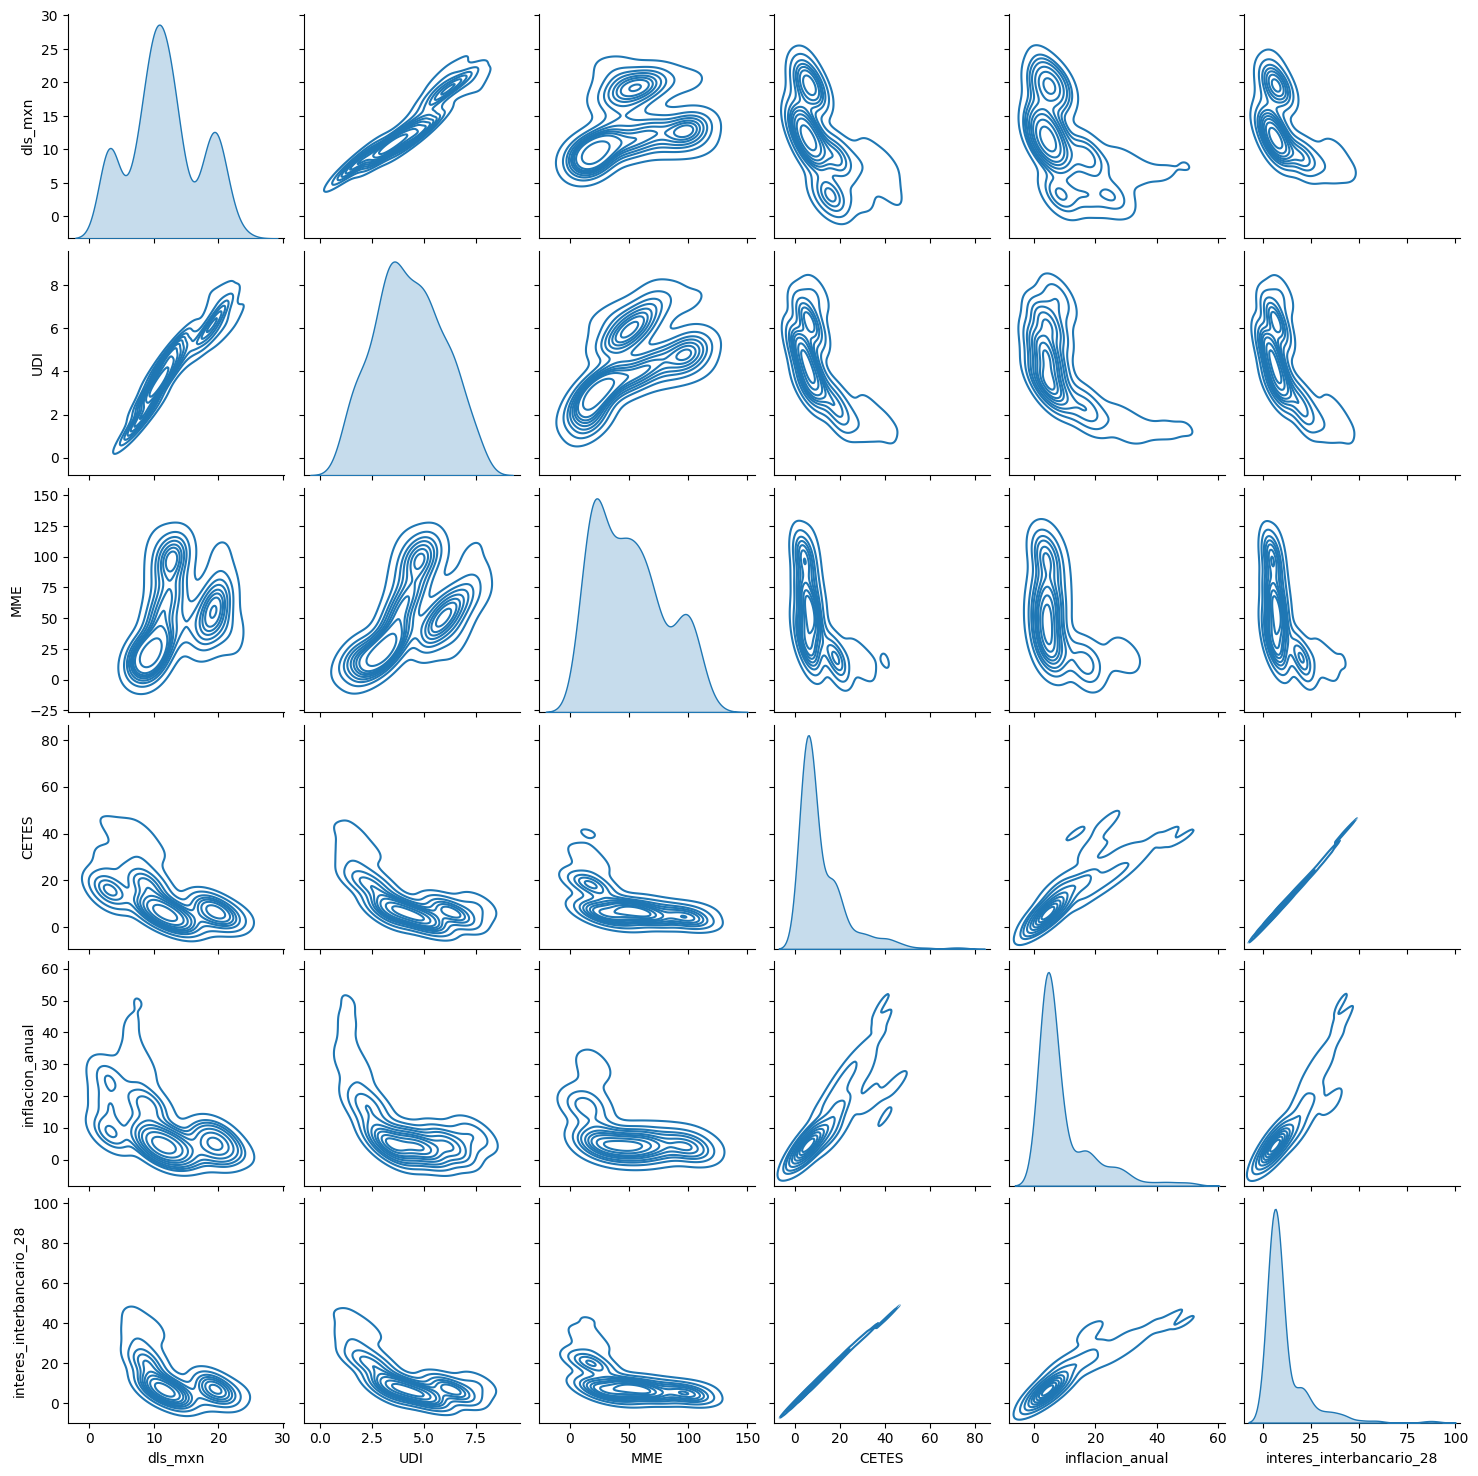

In [31]:
plt.figure(figsize=(10, 10))
sns.pairplot(indicadores_mx, kind='kde')

plt.show()

## Time Series Analysis

[Seasonal Decompose Documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)

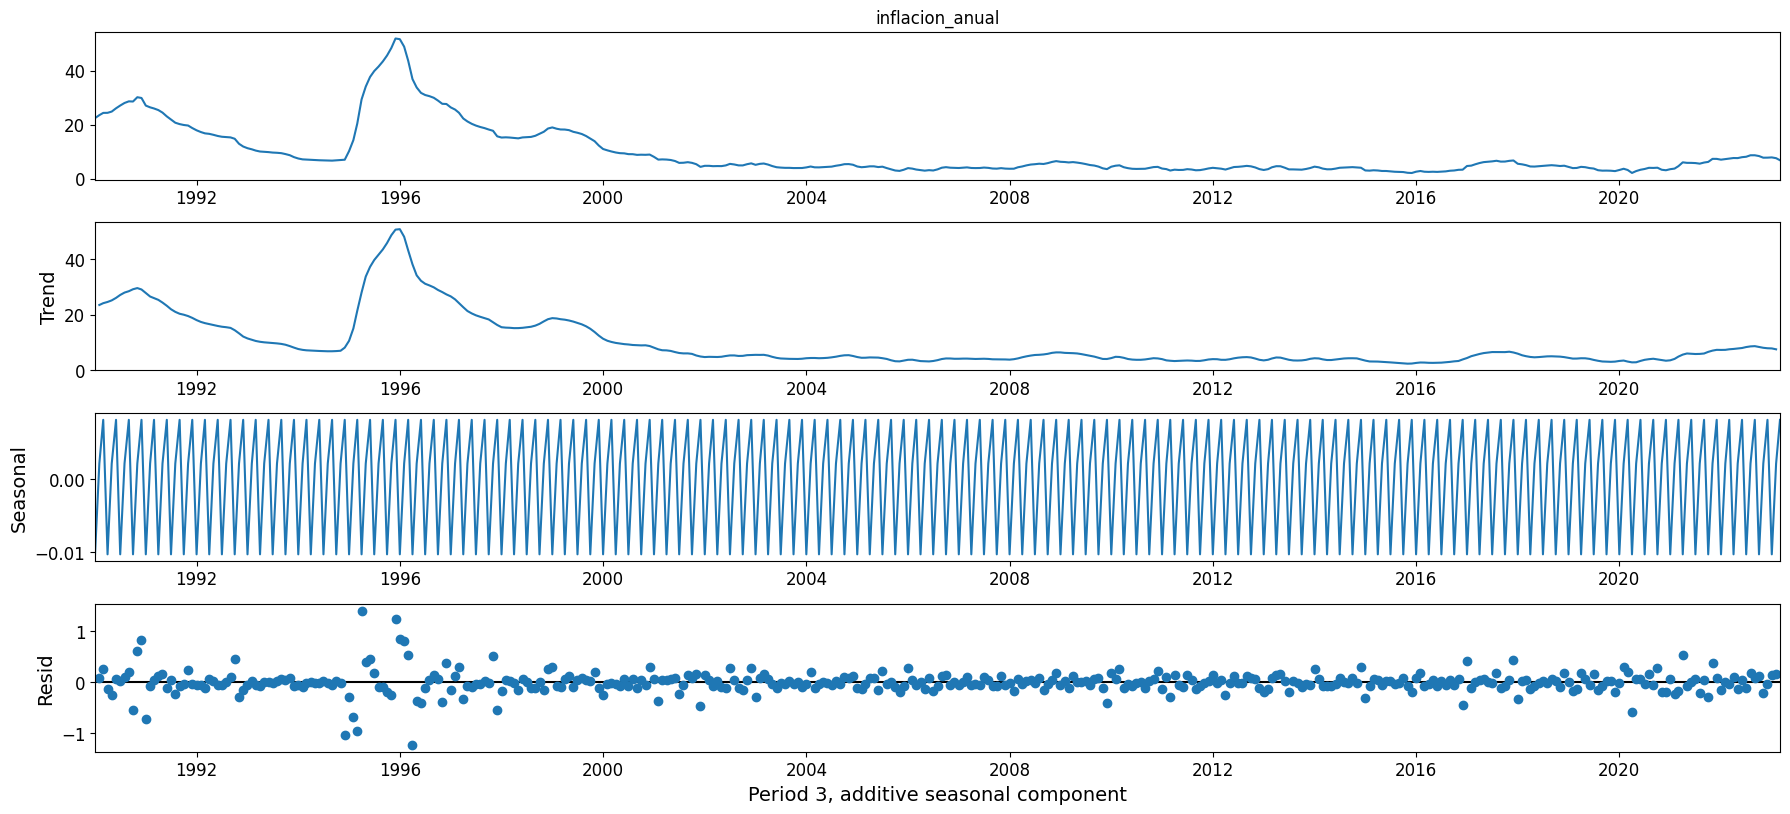

In [33]:
fig = seasonal_decomposition(indicadores_mx.inflacion_anual, 3)

# fig.suptitle('Period 3 (quarter), additive seasonal component')
plt.xlabel('Period 3, additive seasonal component')

plt.show()

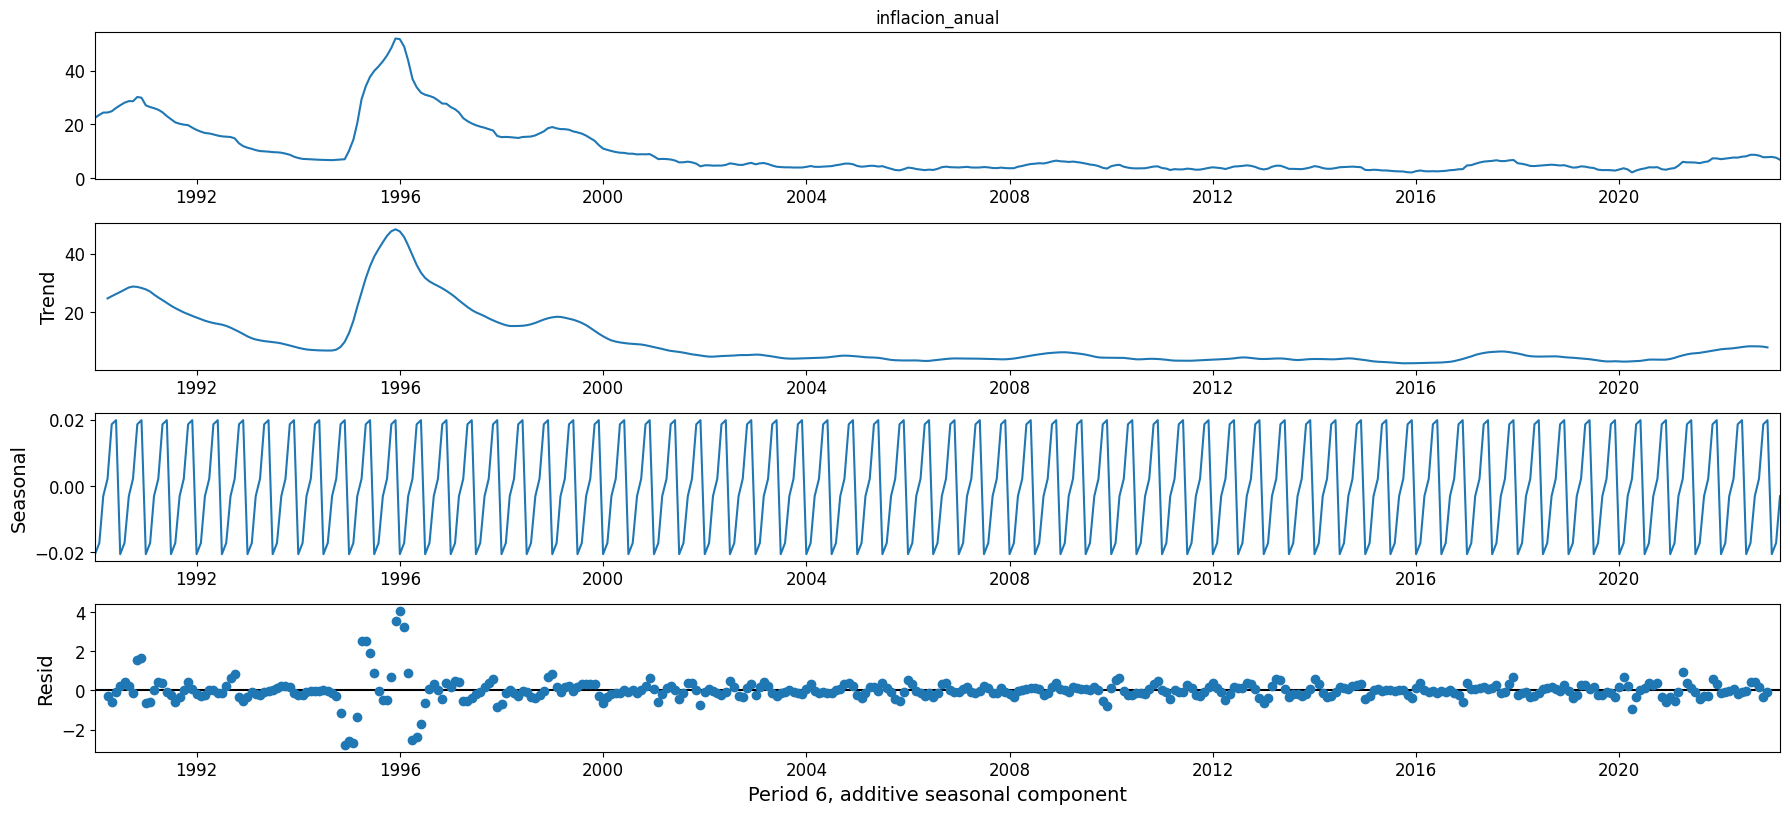

In [35]:
fig = seasonal_decomposition(indicadores_mx.inflacion_anual, 6)

# fig.suptitle('Period 24 (Two years), additive seasonal component')
plt.xlabel('Period 6, additive seasonal component')

plt.show()

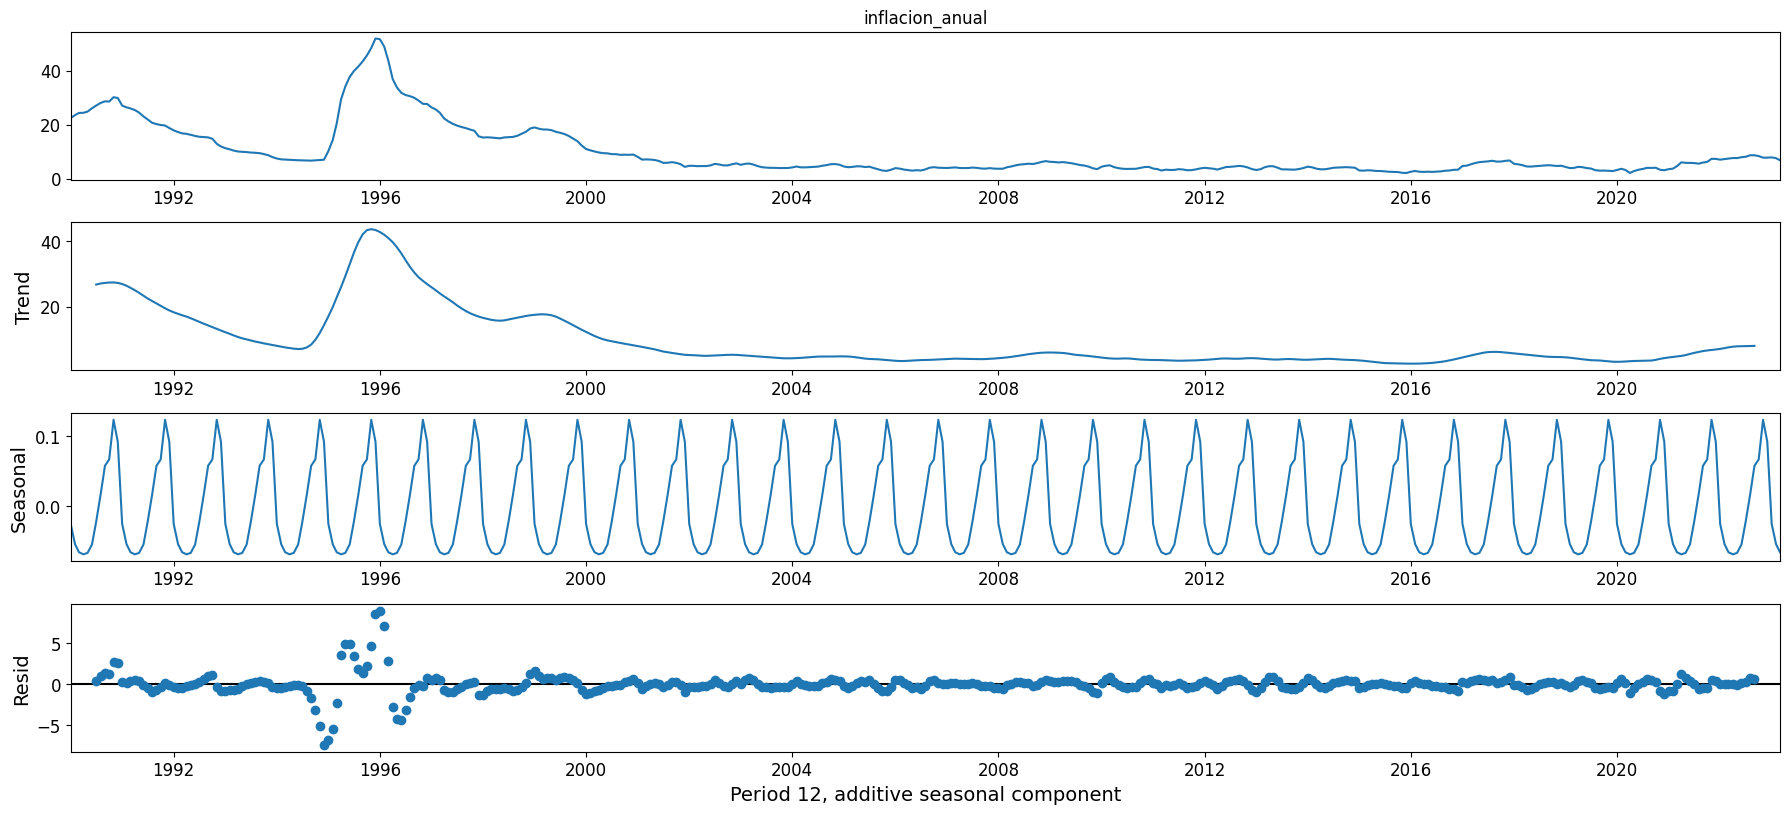

In [32]:
fig = seasonal_decomposition(indicadores_mx.inflacion_anual, 12)

# fig.suptitle('Period 12 (Annual), additive seasonal component')
plt.xlabel('Period 12, additive seasonal component')

plt.show()

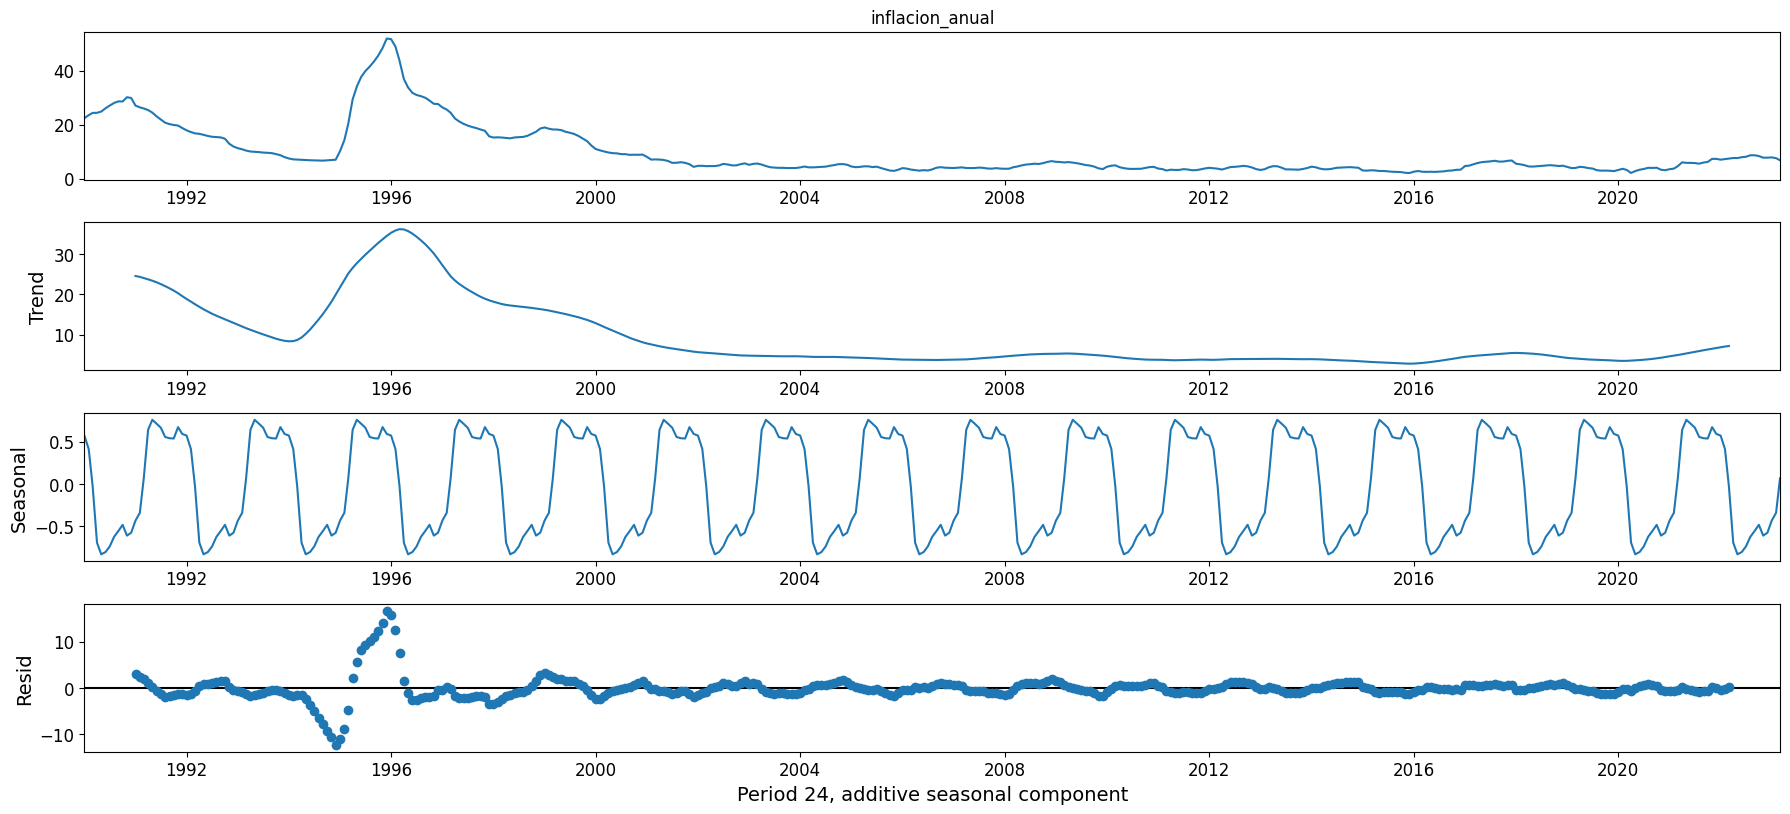

In [34]:
fig = seasonal_decomposition(indicadores_mx.inflacion_anual, 24)

# fig.suptitle('Period 24 (Two years), additive seasonal component')
plt.xlabel('Period 24, additive seasonal component')

plt.show()

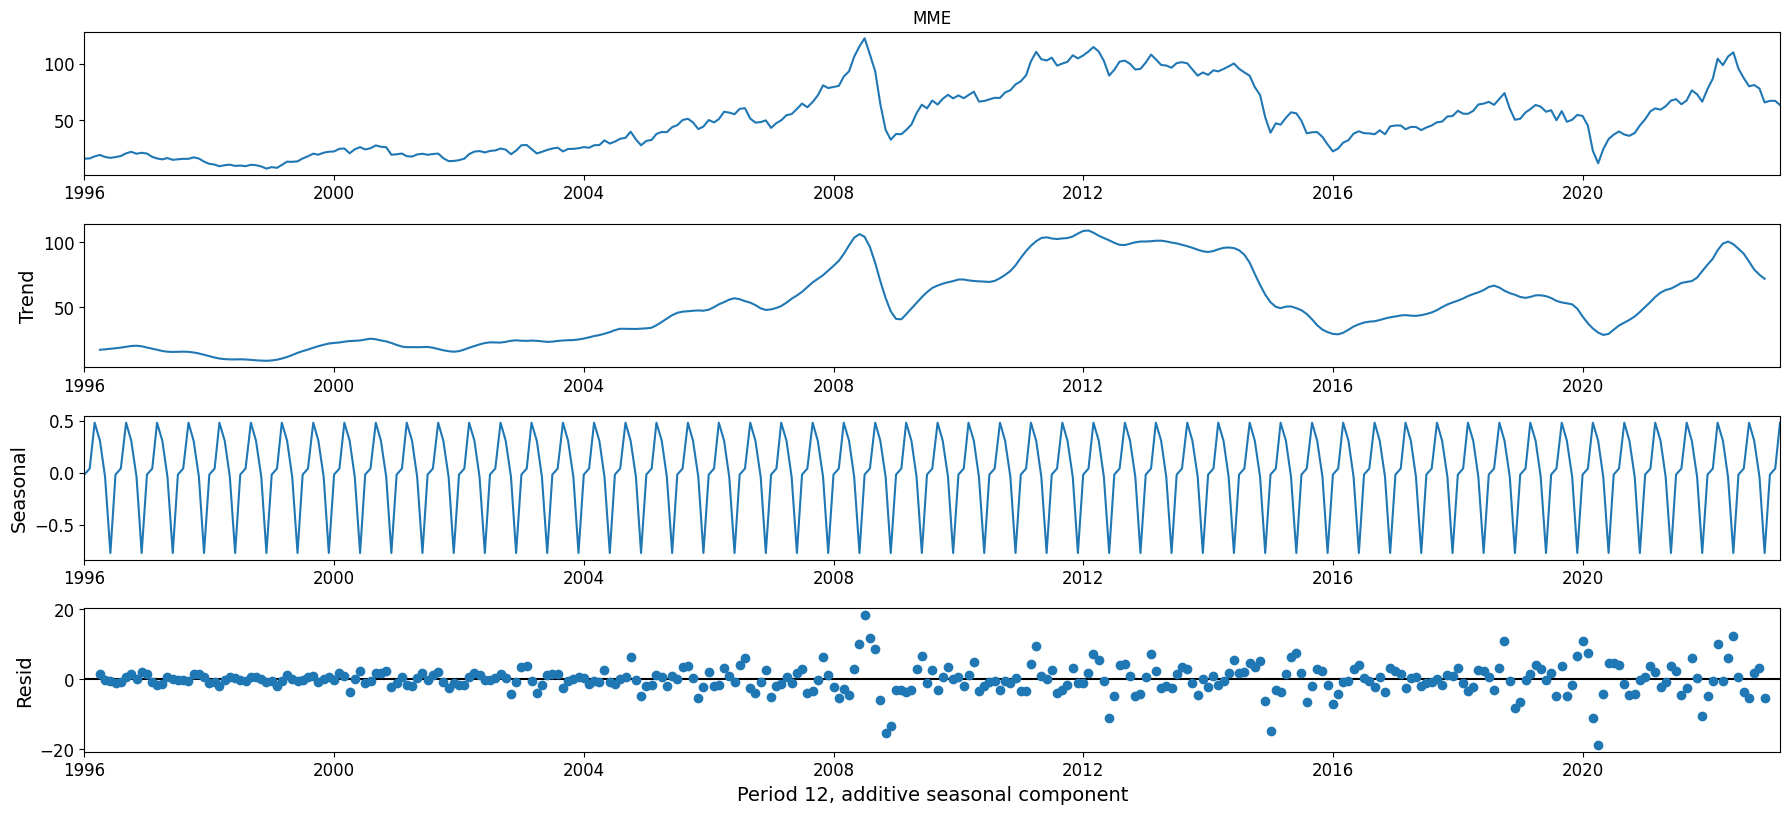

In [38]:
fig = seasonal_decomposition(indicadores_mx['MME'].dropna(), 6)

plt.xlabel('Period 12, additive seasonal component')

plt.show()

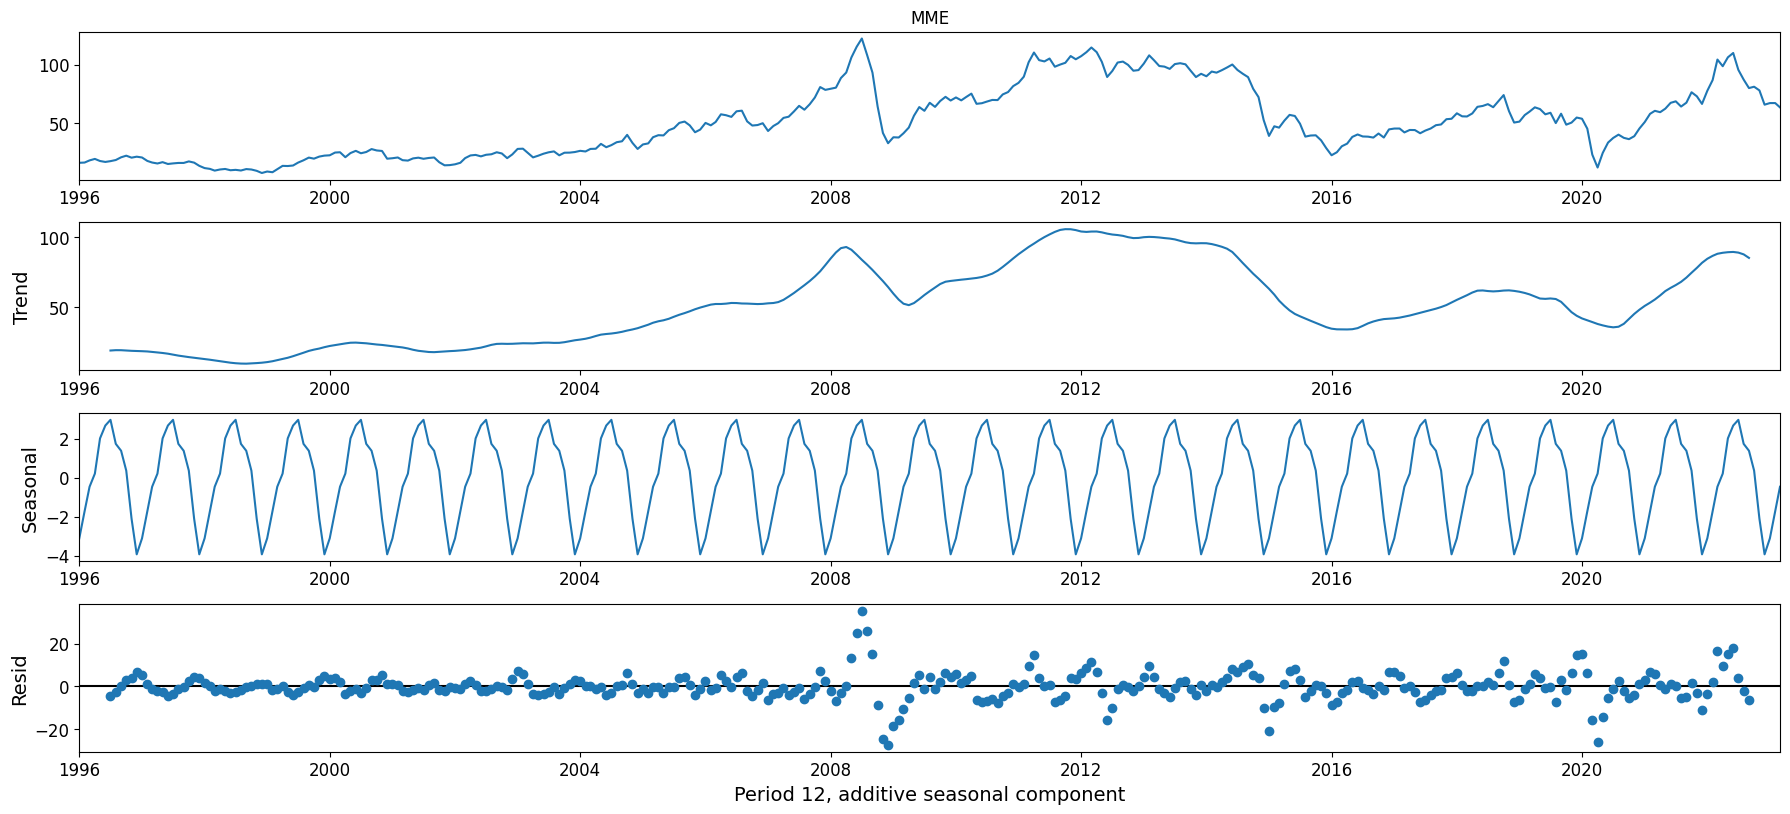

In [36]:
fig = seasonal_decomposition(indicadores_mx['MME'].dropna(), 12)

plt.xlabel('Period 12, additive seasonal component')

plt.show()